# Introduction

In [ ]:
"""
What? Imputing missing values before building an estimator

Reference: https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
"""

# Import

In [20]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Load dataset

In [ ]:
"""
Diabetes dataset is shipped with scikit-learn. It has 442 entries, each with 10 features. California Housing 
dataset is much larger with 20640 entries and 8 features. We will only use the first 400 entries for the sake 
of speeding up the calculations
"""

In [5]:
rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:400]
y_california = y_california[:400]

In [6]:
def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[: n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing

In [7]:
X_miss_california, y_miss_california = add_missing_values(
    X_california, y_california)

X_miss_diabetes, y_miss_diabetes = add_missing_values(
    X_diabetes, y_diabetes)

In [10]:
N_SPLITS = 5
regressor = RandomForestRegressor(random_state=0)

# Missing information

In [ ]:
"""
In addition to imputing the missing values, the imputers have an add_indicator parameter that marks the values 
that were missing, which might carry some information.
"""

In [11]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring='neg_mean_squared_error',
                                    cv=N_SPLITS)
    return impute_scores


x_labels = ['Full data',
            'Zero imputation',
            'Mean Imputation',
            'KNN Imputation',
            'Iterative Imputation']

mses_california = np.zeros(5)
stds_california = np.zeros(5)
mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)

# Estimate the score

In [ ]:
"""
First, we want to estimate the score on the original data:
"""

In [12]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(regressor, X_full, y_full,
                                  scoring='neg_mean_squared_error',
                                  cv=N_SPLITS)
    return full_scores.mean(), full_scores.std()


mses_california[0], stds_california[0] = get_full_score(X_california,
                                                        y_california)
mses_diabetes[0], stds_diabetes[0] = get_full_score(X_diabetes, y_diabetes)

# Replace missing values by 0

In [ ]:
"""
Now we will estimate the score on the data where the missing values are replaced by 0:
"""

In [13]:
def get_impute_zero_score(X_missing, y_missing):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_california[1], stds_california[1] = get_impute_zero_score(
    X_miss_california, y_miss_california)
mses_diabetes[1], stds_diabetes[1] = get_impute_zero_score(X_miss_diabetes,
                                                           y_miss_diabetes)

# kNN-imputation of the missing values

In [ ]:
"""
KNNImputer imputes missing values using the weighted or unweighted mean of the desired number of nearest neighbors.
"""

In [17]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_california[2], stds_california[2] = get_impute_knn_score(
    X_miss_california, y_miss_california)
mses_diabetes[2], stds_diabetes[2] = get_impute_knn_score(X_miss_diabetes,
                                                          y_miss_diabetes)

# Impute missing values with mean

In [18]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean",
                            add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_california[3], stds_california[3] = get_impute_mean(X_miss_california,
                                                         y_miss_california)
mses_diabetes[3], stds_diabetes[3] = get_impute_mean(X_miss_diabetes,
                                                     y_miss_diabetes)

# Iterative imputation of the missing values

In [ ]:
"""
Another option is the IterativeImputer. This uses round-robin linear regression, modeling each feature with missing 
values as a function of other features, in turn. The version implemented assumes Gaussian (output) variables. If 
your features are obviously non-normal, consider transforming them to look more normal to potentially improve 
performance.
"""

In [19]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(missing_values=np.nan, add_indicator=True,
                               random_state=0, n_nearest_features=5,
                               sample_posterior=True)
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses_california[4], stds_california[4] = get_impute_iterative(
    X_miss_california, y_miss_california)
mses_diabetes[4], stds_diabetes[4] = get_impute_iterative(X_miss_diabetes,
                                                          y_miss_diabetes)

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

# Plotting

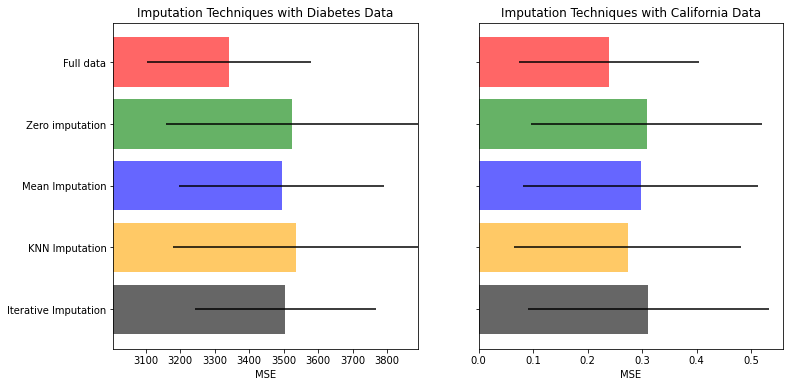

In [21]:
n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ['r', 'g', 'b', 'orange', 'black']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_diabetes[j], xerr=stds_diabetes[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques with Diabetes Data')
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9,
             right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(j, mses_california[j], xerr=stds_california[j],
             color=colors[j], alpha=0.6, align='center')

ax2.set_title('Imputation Techniques with California Data')
ax2.set_yticks(xval)
ax2.set_xlabel('MSE')
ax2.invert_yaxis()
ax2.set_yticklabels([''] * n_bars)

plt.show()

# You can also try different techniques. For instance, the median is a more
# robust estimator for data with high magnitude variables which could dominate
# results (otherwise known as a 'long tail').